In [40]:
!pip install torchinfo

# Imports

In [41]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize

# Data Loading

In [42]:
DATA_DIR = "/kaggle/input/taeleaf-dataset"   
OUTPUT_DIR = "/kaggle/working/"         

print("Data Directory:", DATA_DIR)
print("Output Directory:", OUTPUT_DIR)


Data Directory: /kaggle/input/taeleaf-dataset
Output Directory: /kaggle/working/


In [43]:
# Preprocessing & Augmentation
# ---------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [44]:
# Load dataset, split, dataloaders

full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total Images:", len(full_dataset))


Classes: ['Leaf that not to be used to make tea', 'Leaf that uses to make tea']
Total Images: 747


In [45]:
# Split: 70% train, 20% val, 10% test (as in your notebook)
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])

# Set transforms for splits
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

print("Split sizes -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Split sizes -> Train: 522 Val: 149 Test: 76


# Model definition

In [46]:
# Attention module: Squeeze-and-Excitation (lightweight)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, max(channels // reduction, 4), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(channels // reduction, 4), channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [47]:
# Attention-Enhanced CNN (replace CustomCNN)

class AttentionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AttentionCNN, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.layer1 = nn.Sequential(
            conv_block(3, 32),
            nn.MaxPool2d(2)  # 112x112
        )
        self.se1 = SEBlock(32, reduction=8)

        self.layer2 = nn.Sequential(
            conv_block(32, 64),
            nn.MaxPool2d(2)  # 56x56
        )
        self.se2 = SEBlock(64, reduction=8)

        self.layer3 = nn.Sequential(
            conv_block(64, 128),
            nn.MaxPool2d(2)  # 28x28
        )
        self.se3 = SEBlock(128, reduction=8)

        self.layer4 = nn.Sequential(
            conv_block(128, 256),
            nn.MaxPool2d(2)  # 14x14
        )
        self.se4 = SEBlock(256, reduction=8)

        self.layer5 = nn.Sequential(
            conv_block(256, 512),
            nn.MaxPool2d(2)  # 7x7
        )
        self.se5 = SEBlock(512, reduction=8)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x); x = self.se1(x)
        x = self.layer2(x); x = self.se2(x)
        x = self.layer3(x); x = self.se3(x)
        x = self.layer4(x); x = self.se4(x)
        x = self.layer5(x); x = self.se5(x)
        x = self.classifier(x)
        return x


# Device + Optimizer

In [48]:
# Setup device, model, optimizer, loss

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = AttentionCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Device: cuda


# Training

In [49]:
# Train and validate functions (with timing)

def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start = time.time()
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_time = time.time() - start
    return running_loss / total, correct / total, epoch_time

def validate(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, correct / total

In [50]:
# Training loop with early stopping & timing

best_val_loss = float("inf")
patience = 3
wait = 0

EPOCHS = 5
train_losses, val_losses = [], []
epoch_times = []

train_start_time = time.time()

for epoch in range(EPOCHS):

    train_loss, train_acc, epoch_time = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{EPOCHS} | train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} val_acc: {val_acc:.4f} | epoch_time: {epoch_time:.1f}s")

   
    # Save best model 
  
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_path = os.path.join(OUTPUT_DIR, "best_attention_cnn_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(" ** Saved Best Attention Model **")

    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break  
            
total_training_time = time.time() - train_start_time
print(f"\nTotal training time: {total_training_time:.1f}s (sum of epoch times: {sum(epoch_times):.1f}s)")


Epoch 1/5 | train_loss: 1.0638 train_acc: 0.7759 | val_loss: 1.6284 val_acc: 0.4765 | epoch_time: 91.8s
 ** Saved Best Attention Model **
Epoch 2/5 | train_loss: 0.1722 train_acc: 0.9483 | val_loss: 2.3183 val_acc: 0.4765 | epoch_time: 90.5s
Epoch 3/5 | train_loss: 0.1594 train_acc: 0.9483 | val_loss: 0.8619 val_acc: 0.7718 | epoch_time: 91.0s
 ** Saved Best Attention Model **
Epoch 4/5 | train_loss: 0.1412 train_acc: 0.9598 | val_loss: 0.0980 val_acc: 0.9530 | epoch_time: 91.2s
 ** Saved Best Attention Model **
Epoch 5/5 | train_loss: 0.1219 train_acc: 0.9559 | val_loss: 0.0835 val_acc: 0.9664 | epoch_time: 91.5s
 ** Saved Best Attention Model **

Total training time: 584.7s (sum of epoch times: 455.9s)


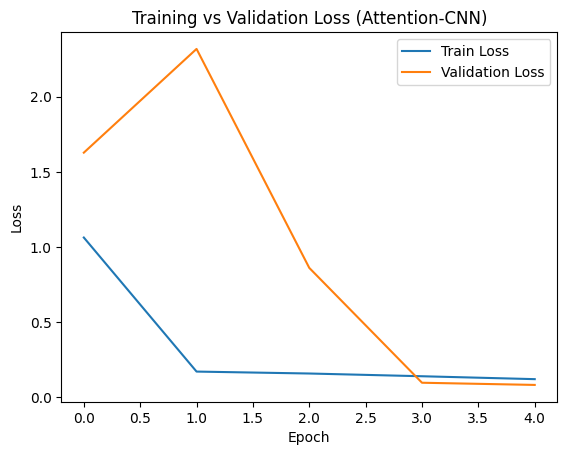

In [51]:
# Plot training curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss (Attention-CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [52]:
# Load best model & Evaluate on test set (with timing)

best_model_path = os.path.join(OUTPUT_DIR, "best_attention_cnn_model.pth")
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model from:", best_model_path)
else:
    print("Best model not found - using current weights")

model.eval()
test_start_time = time.time()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)  # logits
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

test_duration = time.time() - test_start_time
print(f"Test evaluation time: {test_duration:.2f}s")

Loaded best model from: /kaggle/working/best_attention_cnn_model.pth
Test evaluation time: 12.64s


In [53]:
# Compute Metrics
# Basic metrics

acc = accuracy_score(y_true, y_pred)
prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Test Metrics (Attention-CNN) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Test duration (s): {test_duration:.2f}")
print(f"Total training time (s): {total_training_time:.2f}")



=== Test Metrics (Attention-CNN) ===
Accuracy : 0.9737
Precision: 0.9753
Recall   : 0.9737
F1-score : 0.9738
Test duration (s): 12.64
Total training time (s): 584.69


In [54]:
# Per-class accuracy
class_correct = np.zeros(num_classes, dtype=int)
class_total = np.zeros(num_classes, dtype=int)
for t, p in zip(y_true, y_pred):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

print("\nPer-class accuracy:")
for i, cls in enumerate(class_names):
    acc_i = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{cls}: {acc_i:.3f} ({class_correct[i]}/{class_total[i]})")


Per-class accuracy:
Leaf that not to be used to make tea: 0.957 (44/46)
Leaf that uses to make tea: 1.000 (30/30)


# Classification report

In [55]:
# Classification report (precision/recall/f1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Classification report:
                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       1.00      0.96      0.98        46
          Leaf that uses to make tea       0.94      1.00      0.97        30

                            accuracy                           0.97        76
                           macro avg       0.97      0.98      0.97        76
                        weighted avg       0.98      0.97      0.97        76



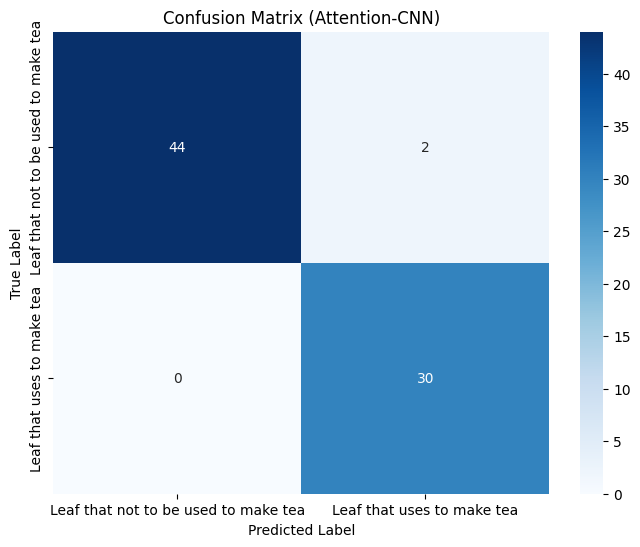

In [56]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Attention-CNN)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [57]:
# AUC & ROC (multiclass one-vs-rest)
# ---------------------------
y_scores = np.array(y_scores)
y_true_arr = np.array(y_true)

# Binarize labels
y_true_bin = label_binarize(y_true_arr, classes=list(range(num_classes)))
# Safety: align columns if mismatch
if y_true_bin.shape[1] != y_scores.shape[1]:
    n_cols = min(y_true_bin.shape[1], y_scores.shape[1])
    y_true_bin = y_true_bin[:, :n_cols]
    y_scores = y_scores[:, :n_cols]

auc_per_class = {}
for i in range(y_true_bin.shape[1]):
    try:
        auc = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[class_names[i]] = auc

print("\nAUC per class:")
for cls, a in auc_per_class.items():
    print(f"{cls}: {np.round(a, 4)}")


AUC per class:
Leaf that not to be used to make tea: 0.0036


In [58]:
# Macro & micro AUC (OVR)
try:
    auc_macro = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_scores, average='micro', multi_class='ovr')
except ValueError:
    auc_macro = auc_micro = float('nan')

print(f"\nAUC (macro): {auc_macro:.4f}")
print(f"AUC (micro): {auc_micro:.4f}")


AUC (macro): 0.0036
AUC (micro): 0.0036


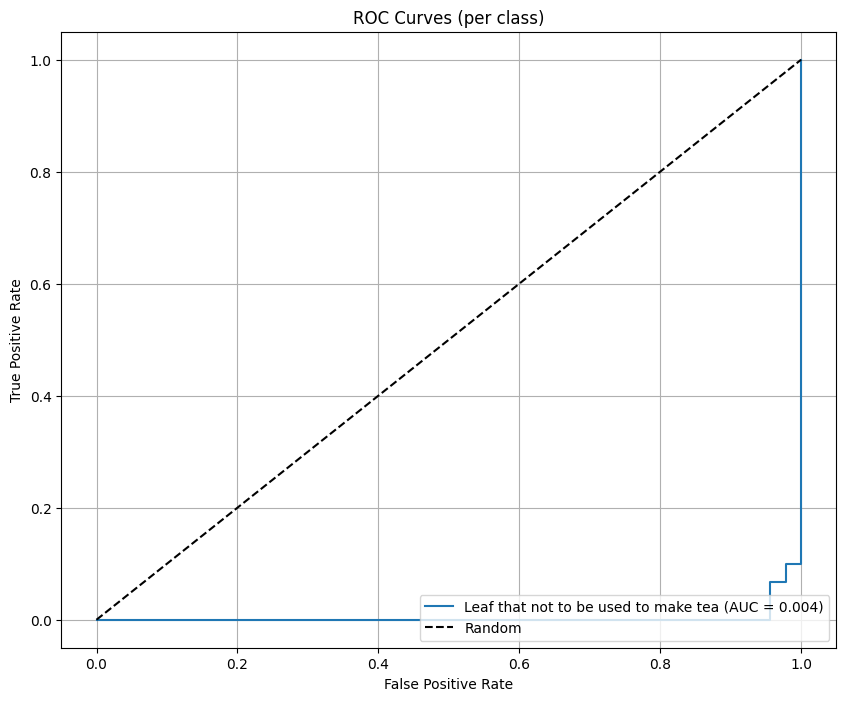

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_per_class[class_names[i]]:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC Curves (per class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Final test loss/accuracy

In [60]:
# Final test loss/accuracy
test_loss, test_acc = validate(test_loader)
print(f"\nFinal test loss: {test_loss:.4f} | Final test acc: {test_acc:.4f}")


Final test loss: 0.0731 | Final test acc: 0.9737
